In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

#合并两个文档
data_train = pd.read_csv('./input/train.csv')
data_test = pd.read_csv('./input/test.csv') #这里读取的是一个读取的Pandas格式
combine = [data_train, data_test] #这是一个列表


['gender_submission.csv', 'submission.csv', 'test.csv', 'train.csv']


In [3]:
#每行缺失值
#data_train.shape[1] - data_train.count(axis=1)
#每列缺失值
data_train.shape[0] - data_train.count()
#这里的结果和我在博客看到的不符，但经过检查，结果无误。猜测：官方更改了数据集

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#查看预测样本集合内缺失
data_test.shape[0] - data_test.count()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [5]:
data_train.shape


(891, 12)

In [6]:
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
data_train.dtypes


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

<AxesSubplot:>

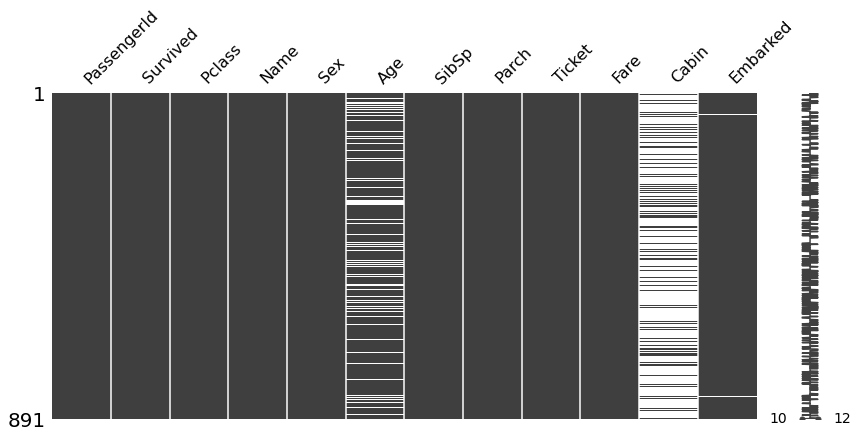

In [8]:
#此处记录一个非常强悍的查看缺失值的方法
import missingno as msno
msno.matrix(data_train,figsize=(14,6))#figsize制图大小

In [9]:
data_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
#方法一：填充中位数
age_median = data_train.Age.median()
age_median


28.0

In [11]:
#方法二：根据每个人对应的称谓中位数填充，更加准确，如miss和Mrs可能年龄不同
#1.检查称谓
count = 0 #count the number of names without "Mr./Miss./Master./Dr./Mrs."
def check_if_the_name_including_reguler(dataset,count):
    for data in dataset.Name:
        if ("Mr." not in data) & ("Miss." not in data) & ("Master." not in data) & ("Dr." not in data) & ("Mrs." not in data):
            print(data)
            count = count +1
    print("\nthe number of names without 'Mr./Miss./Master./Dr./Mrs.' is " + str(count))
    return count

check_if_the_name_including_reguler(data_train,count)


Uruchurtu, Don. Manuel E
Byles, Rev. Thomas Roussel Davids
Bateman, Rev. Robert James
Carter, Rev. Ernest Courtenay
Aubart, Mme. Leontine Pauline
Reynaldo, Ms. Encarnacion
Peuchen, Major. Arthur Godfrey
Butt, Major. Archibald Willingham
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")
Kirkland, Rev. Charles Leonard
Sagesser, Mlle. Emma
Simonius-Blumer, Col. Oberst Alfons
Weir, Col. John
Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")
Crosby, Capt. Edward Gifford
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)
Reuchlin, Jonkheer. John George
Harper, Rev. John
Montvila, Rev. Juozas

the number of names without 'Mr./Miss./Master./Dr./Mrs.' is 20


20

In [12]:
#统计每种称谓的平均年龄
age_in = []   #Mr./Miss./Master./Dr./Mrs.
for i in range(0,5):
    age_in.insert(0,[0,0])
def count_every_call_mid(data_train,age_in):
    #data_train.ix["Miss." in data_train.Name]
    for data in data_train.index:
        #print(data_train.loc[data,"Name"])
        if "Mr." in data_train.loc[data,"Name"]:
            if not math.isnan(data_train.loc[data,"Age"]) :
                age_in[0][0]+=data_train.loc[data,"Age"]
                age_in[0][1]+=1
        elif "Miss." in data_train.loc[data,"Name"]:
            if not math.isnan(data_train.loc[data,"Age"]) :
                age_in[1][0]+=data_train.loc[data,"Age"]
                age_in[1][1]+=1
        elif "Master." in data_train.loc[data,"Name"]:
            if not math.isnan(data_train.loc[data,"Age"]) :
                age_in[2][0]+=data_train.loc[data,"Age"]
                age_in[2][1]+=1
        elif "Dr." in data_train.loc[data,"Name"]:
            if not math.isnan(data_train.loc[data,"Age"]) :
                age_in[3][0]+=data_train.loc[data,"Age"]
                age_in[3][1]+=1
        elif "Mrs." in data_train.loc[data,"Name"]:
            if not math.isnan(data_train.loc[data,"Age"]) :
                age_in[4][0]+=data_train.loc[data,"Age"]
                age_in[4][1]+=1
    return age_in

count_every_call_mid(data_train,age_in)
age_median = data_train.Age.median()
ave=[0,0,0,0,0]
for i in range(0,5):
    ave[i]=age_in[i][0]/age_in[i][1]
    print(ave[i])#Mr./Miss./Master./Dr./Mrs.


32.368090452261306
21.773972602739725
4.574166666666667
42.0
35.898148148148145


In [13]:
#将各称呼年龄平均年龄填充，非常用称呼用平均年龄填充
def replace_age_by_mid_of_call(dataset):
    for data in dataset.index:
        #print(data_train.loc[data,"Name"])
        if math.isnan(dataset.loc[data,"Age"]) :
            if "Mr." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[0]
            elif "Miss." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[1]
            elif "Master." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[2]
            elif "Dr." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[3]
            elif "Mrs." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[4]
            else:
                dataset.loc[data,"Age"]=age_median
replace_age_by_mid_of_call(data_train)


In [14]:
#此处对于pandas读取的文件和列表有不同的处理格式
#统计整体内除了基本称呼"Mr./Miss./Master./Dr./Mrs."以外的称呼占总体称呼的多少
count = 0
for dataset in combine:
    count = check_if_the_name_including_reguler(dataset,count)
    print("\n")


Uruchurtu, Don. Manuel E
Byles, Rev. Thomas Roussel Davids
Bateman, Rev. Robert James
Carter, Rev. Ernest Courtenay
Aubart, Mme. Leontine Pauline
Reynaldo, Ms. Encarnacion
Peuchen, Major. Arthur Godfrey
Butt, Major. Archibald Willingham
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")
Kirkland, Rev. Charles Leonard
Sagesser, Mlle. Emma
Simonius-Blumer, Col. Oberst Alfons
Weir, Col. John
Mayne, Mlle. Berthe Antonine ("Mrs de Villiers")
Crosby, Capt. Edward Gifford
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)
Reuchlin, Jonkheer. John George
Harper, Rev. John
Montvila, Rev. Juozas

the number of names without 'Mr./Miss./Master./Dr./Mrs.' is 20


O'Donoghue, Ms. Bridget
Gracie, Col. Archibald IV
Lahtinen, Rev. William
Peruschitz, Rev. Joseph Maria
Astor, Col. John Jacob
Oliva y Ocana, Dona. Fermina

the number of names without 'Mr./Miss./Master./Dr./Mrs.' is 26




In [15]:
#统计所有样本中，每种称谓的平均年龄：
age_in = []   #Mr./Miss./Master./Dr./Mrs.
for i in range(0,5):
    age_in.insert(0,[0,0])
for dataset in combine:
    age_in = count_every_call_mid(dataset,age_in)
age_median = data_train.Age.median()
ave=[0,0,0,0,0]
for i in range(0,5):
    ave[i]=age_in[i][0]/age_in[i][1]
    print(ave[i])#Mr./Miss./Master./Dr./Mrs.


32.271861091170095
21.77419924267737
5.418888888888889
43.375
36.894484056248764


In [16]:
#用新的平均值填充
def replace_age_by_mid_of_call(dataset):
    for data in dataset.index:
        #print(data_train.loc[data,"Name"])
        if math.isnan(dataset.loc[data,"Age"]) :
            if "Mr." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[0]
            elif "Miss." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[1]
            elif "Master." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[2]
            elif "Dr." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[3]
            elif "Mrs." in dataset.loc[data,"Name"]:
                dataset.loc[data,"Age"]=ave[4]
            else:
                dataset.loc[data,"Age"]=age_median

for dataset in combine:
    replace_age_by_mid_of_call(dataset)


In [17]:
#检查样本是否被填充
data_test.shape[0] - data_test.count()
#检查样本是否被填充
#data_train.shape[0] - data_train.count()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [18]:
#方法二：利用
def replaceCabin(data):
    data['Cabin'] = data['Cabin'].fillna('X')
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
    data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
    data['Cabin'] = data['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3}).astype(int)

# def replaceCabin(data):
#     data['Cabin'] = data['Cabin'].fillna('X')
#     data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
# #     data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
# #     data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
# #     data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
#     data['Cabin'] = data['Cabin'].map({'X': 0, 'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'T':8}).astype(int) 

for dataset in combine:
    replaceCabin(dataset)


In [19]:
# for dataset in combine:
#     print(dataset)
#     if 'male' not in dataset['Sex']:
#          print(dataset['Sex'])
#     dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

# data_train.head()
data_train.replace({'Sex':{'female':1,'male':2}},inplace=True)
# #处理预测样本集
data_test.replace({'Sex':{'female':1,'male':2}},inplace=True)


In [20]:
#方法一：选择平均值填充
fare_median = data_test.Fare.median()
data_test['Fare'].fillna(data_test['Fare'].dropna().median(), inplace=True)


In [21]:
#抽取前五个样本，查看是否所有特征均得到合适处理
data_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",2,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,3,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,3,S
4,5,0,3,"Allen, Mr. William Henry",2,35.0,0,0,373450,8.0500,0,S


In [22]:
#检查预测样本集是否对特征进行了处理
data_test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",2,34.5,0,0,330911,7.8292,0,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,0,S
2,894,2,"Myles, Mr. Thomas Francis",2,62.0,0,0,240276,9.6875,0,Q
3,895,3,"Wirz, Mr. Albert",2,27.0,0,0,315154,8.6625,0,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,0,S


In [23]:
# Ticket
df = data_train['Ticket'].value_counts()
df = pd.DataFrame(df)
df = df[df['Ticket'] > 1]
df_ticket = df.index.values        #共享船票的票号
tickets = data_train.Ticket.values    #所有的船票
result = []
for ticket in tickets:
    if ticket in df_ticket:
        ticket = 1
    else:
        ticket = 0                 #遍历所有船票，在共享船票里面的为1，否则为0
    result.append(ticket)
results = pd.DataFrame(result)
results.columns = ['Ticket_Count']
data_train = pd.concat([data_train, results], axis=1)

df = data_test['Ticket'].value_counts()
df = pd.DataFrame(df)
df = df[df['Ticket'] > 1]
df_ticket = df.index.values        #共享船票的票号
tickets = data_test.Ticket.values    #所有的船票
result = []
for ticket in tickets:
    if ticket in df_ticket:
        ticket = 1
    else:
        ticket = 0                 #遍历所有船票，在共享船票里面的为1，否则为0
    result.append(ticket)
results = pd.DataFrame(result)
results.columns = ['Ticket_Count']
data_test = pd.concat([data_test, results], axis=1)


In [24]:
# Cabin
for dataset in combine:
    dataset.loc[(dataset.Cabin.isnull()), 'Cabin'] = 0
    dataset.loc[(dataset.Cabin.notnull()), 'Cabin'] = 1


In [25]:
#方法一：因为只有两个，直接丢去
data_train = data_train.dropna(subset=['Embarked'])
# for data in combine:
#     data.loc[data['Embarked']=='S']=1
#     data.loc[data['Embarked']=='C']=2
#     data.loc[data['Embarked']=='Q']=2
data_train = data_train.replace({'Embarked':{'S':1,'C':2,'Q':3}})
data_test = data_test.replace({'Embarked':{'S':1,'C':2,'Q':3}})


In [26]:
data_test.shape[0] - data_test.count()


PassengerId     0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
Ticket_Count    0
dtype: int64

In [27]:
data_train.shape[0] - data_train.count()


PassengerId     0
Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
Ticket_Count    0
dtype: int64

In [28]:
#特征
data_test_X  = data_test[['Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare', 'Embarked','Ticket_Count','Cabin']]
X_train = data_train[['Pclass', 'Sex', 'Age','SibSp', 'Parch', 'Fare', 'Embarked','Ticket_Count','Cabin']]
Y_train = data_train['Survived']
X_test = data_test_X


In [29]:
#模型比较
#随机森林
random_forest = RandomForestClassifier(n_estimators=300, max_depth=5, criterion='entropy')
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)


In [30]:
#模型写出
submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./input/submission.csv', index=False)
